<a href="https://colab.research.google.com/github/hardinet/Projets-Personnels-/blob/main/Maintenance_Predictive_Moteur.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Le Code B (Chargement des fichiers locaux)

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score

# Configuration visuelle
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

print("📂 Lecture des fichiers locaux...")

# Définition des noms de colonnes (car le fichier texte n'en a pas)
col_names = ['unit_nr', 'time_cycles', 'setting_1', 'setting_2', 'setting_3'] + \
            ['s_{}'.format(i) for i in range(1, 22)]

try:
    # Lecture des fichiers présents dans Colab
    # sep=r'\s+' gère les espaces multiples entre les chiffres
    train_df = pd.read_csv('train_FD001.txt', sep=r'\s+', header=None, names=col_names)
    test_df = pd.read_csv('test_FD001.txt', sep=r'\s+', header=None, names=col_names)
    truth_df = pd.read_csv('RUL_FD001.txt', sep=r'\s+', header=None, names=['RUL'])

    print("\n✅ SUCCÈS : Données chargées !")
    print(f"Dimensions Train: {train_df.shape}")
    print(f"Dimensions Test: {test_df.shape}")

    # Aperçu des 5 premières lignes
    display(train_df.head())

except FileNotFoundError:
    print("❌ Erreur : Colab ne trouve pas les fichiers. Vérifiez qu'ils sont bien dans le dossier à gauche.")

📂 Lecture des fichiers locaux...

✅ SUCCÈS : Données chargées !
Dimensions Train: (20631, 26)
Dimensions Test: (13096, 26)


,unit_nr,time_cycles,setting_1,setting_2,setting_3,s_1,s_2,s_3,s_4,s_5,...,s_12,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


✅ Colonne RUL calculée avec succès.


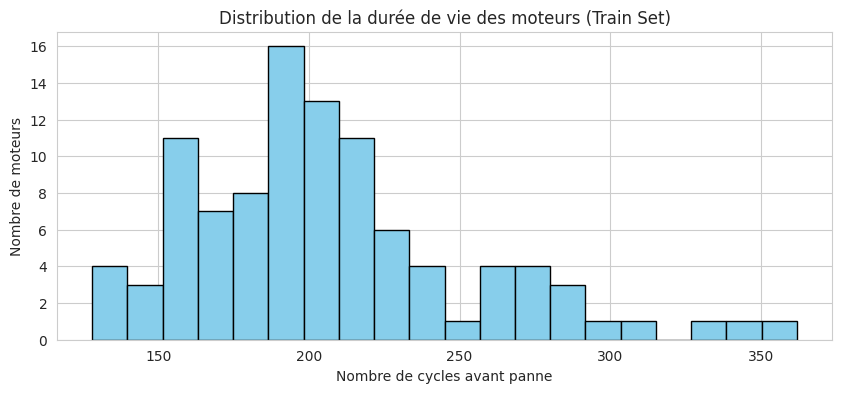

/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


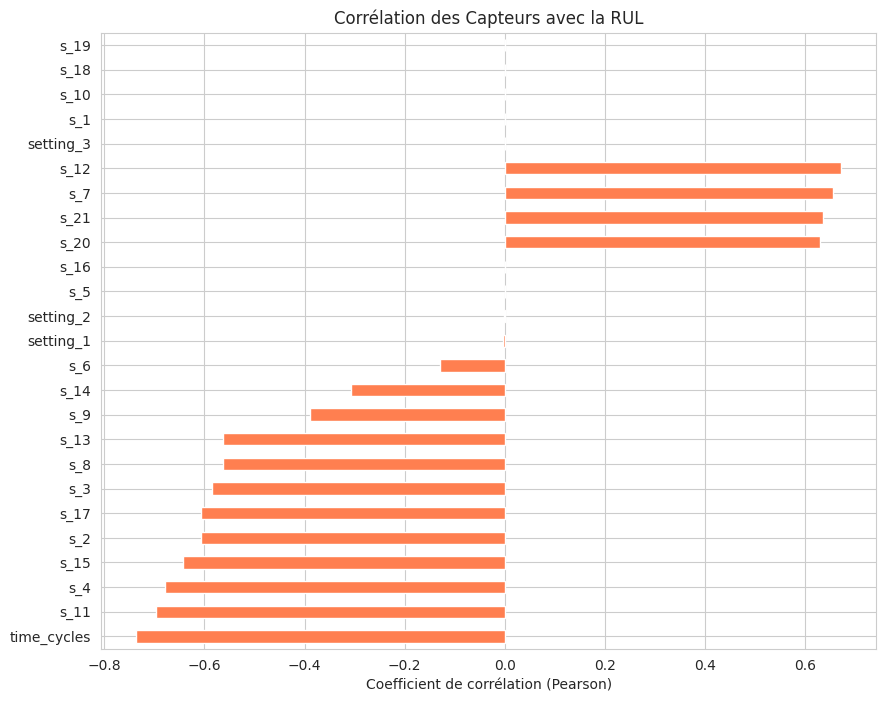

In [34]:
#  : EXPLORATORY DATA ANALYSIS (EDA) ---
# --- CORRECTION : CALCUL DE LA RUL AVANT LES GRAPHIQUES ---

# 1. On calcule  la RUL (Sinon l'ordinateur ne sait pas ce que c'est)
max_cycle = train_df.groupby('unit_nr')['time_cycles'].max().reset_index()
max_cycle.columns = ['unit_nr', 'max_cycle']
train_df = train_df.merge(max_cycle, on='unit_nr', how='left')
train_df['RUL'] = train_df['max_cycle'] - train_df['time_cycles']
train_df.drop('max_cycle', axis=1, inplace=True)

print("✅ Colonne RUL calculée avec succès.")

# 2. MAINTENANT, on peut afficher les graphiques (EDA)
import matplotlib.pyplot as plt

# Histogramme de durée de vie
plt.figure(figsize=(10, 4))
train_df.groupby('unit_nr')['time_cycles'].max().hist(bins=20, color='skyblue', edgecolor='black')
plt.title("Distribution de la durée de vie des moteurs (Train Set)")
plt.xlabel("Nombre de cycles avant panne")
plt.ylabel("Nombre de moteurs")
plt.show()

# Corrélation
correlation = train_df.corrwith(train_df['RUL']).sort_values()

plt.figure(figsize=(10, 8)) # J'ai agrandi un peu la hauteur pour la lisibilité
correlation.drop(['RUL', 'unit_nr']).plot(kind='barh', color='coral')
plt.title("Corrélation des Capteurs avec la RUL")
plt.xlabel("Coefficient de corrélation (Pearson)")
plt.show()

PARTIE 2 : FEATURE ENGINEERING & MODÉLISATION

⚙️ Création des indicateurs avancés...
🚀 Entraînement du modèle sur 28 variables...
✅ Modèle entraîné avec succès !

📊 RÉSULTATS FINAUX :
Erreur Moyenne (RMSE) : 33.03 cycles


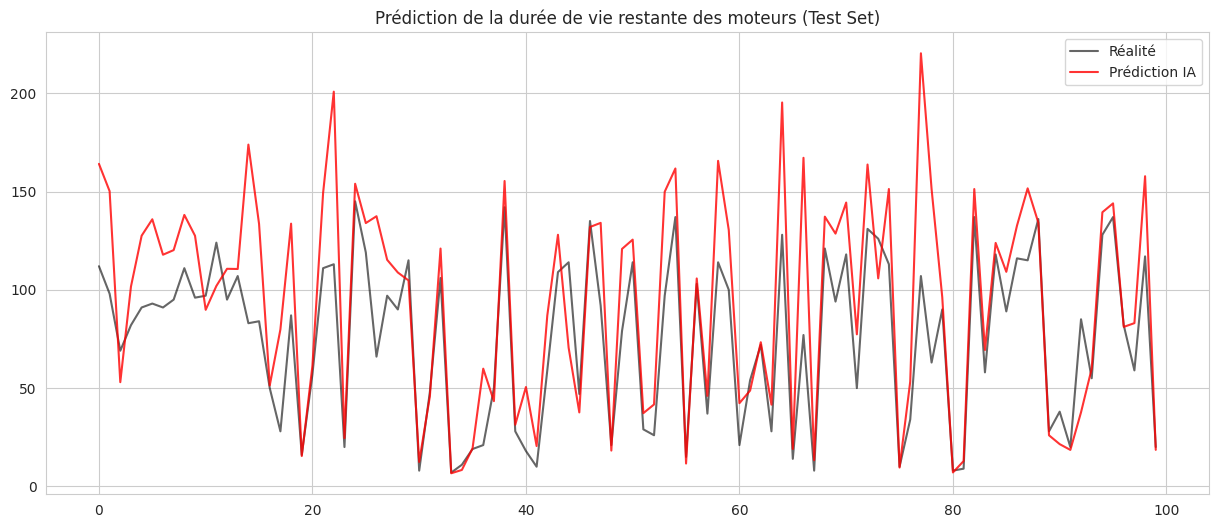

In [35]:
# --- PARTIE 2 : FEATURE ENGINEERING & MODÉLISATION ---

# 1. Calcul de la RUL (Remaining Useful Life) pour l'entraînement
# On détermine combien de temps il reste à chaque moteur avant sa panne max
max_cycle = train_df.groupby('unit_nr')['time_cycles'].max().reset_index()
max_cycle.columns = ['unit_nr', 'max_cycle']
train_df = train_df.merge(max_cycle, on='unit_nr', how='left')
train_df['RUL'] = train_df['max_cycle'] - train_df['time_cycles']
train_df.drop('max_cycle', axis=1, inplace=True)

# 2. Création de Moyennes Glissantes (Rolling Mean)
# Cela permet de lisser le bruit des capteurs pour mieux voir la tendance
sensors_to_use = ['s_2', 's_3', 's_4', 's_7', 's_8', 's_9', 's_11', 's_12', 's_13', 's_14', 's_15', 's_17', 's_20', 's_21']

def add_rolling_features(df, sensors, window_size=5):
    # On groupe par moteur pour ne pas mélanger les données
    rolling = df.groupby('unit_nr')[sensors].rolling(window=window_size).mean()
    # On nettoie l'index pour recoller au dataframe original
    rolling = rolling.reset_index().drop(['level_1', 'unit_nr'], axis=1)
    rolling.columns = [f"{col}_rolling" for col in sensors]
    return pd.concat([df, rolling], axis=1)

print("⚙️ Création des indicateurs avancés...")
train_df = add_rolling_features(train_df, sensors_to_use)
test_df = add_rolling_features(test_df, sensors_to_use)

# On supprime les premières lignes qui contiennent des NaN à cause du glissement
train_df.dropna(inplace=True)
test_df.dropna(inplace=True)

# 3. Entraînement du Modèle XGBoost
features = sensors_to_use + [f"{col}_rolling" for col in sensors_to_use]
X_train = train_df[features]
y_train = train_df['RUL']

print(f"🚀 Entraînement du modèle sur {X_train.shape[1]} variables...")
model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=4, random_state=42)
model.fit(X_train, y_train)
print("✅ Modèle entraîné avec succès !")

# 4. Évaluation sur le jeu de Test
# On prend uniquement la dernière ligne de chaque moteur du test pour comparer
X_test_last = test_df.groupby('unit_nr').last().reset_index()
y_pred = model.predict(X_test_last[features])
y_true = truth_df['RUL']

# Calcul des scores
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
print(f"\n📊 RÉSULTATS FINAUX :")
print(f"Erreur Moyenne (RMSE) : {rmse:.2f} cycles")

# 5. Graphique de Comparaison
plt.figure(figsize=(15, 6))
plt.plot(y_true, label='Réalité', color='black', alpha=0.6)
plt.plot(y_pred, label='Prédiction IA', color='red', alpha=0.8)
plt.title("Prédiction de la durée de vie restante des moteurs (Test Set)")
plt.legend()
plt.show()

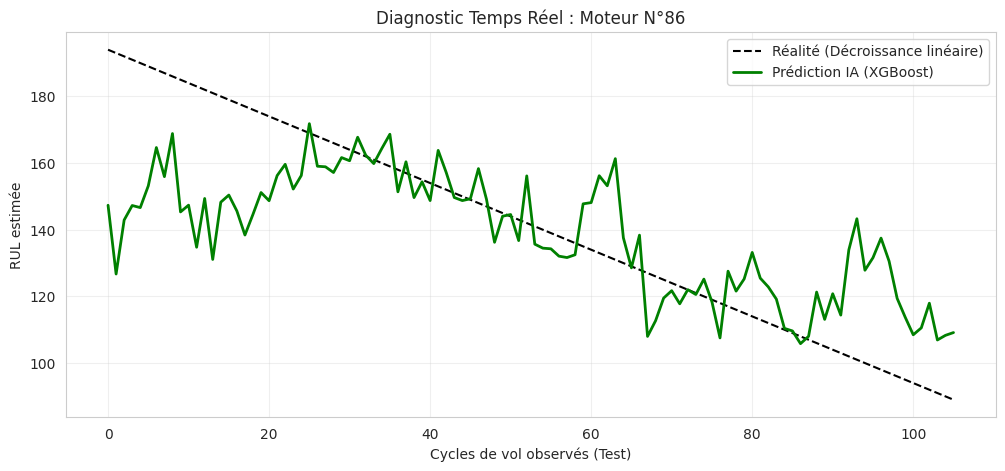

In [36]:
# : VISUALISATION DÉTAILLÉE D'UN MOTEUR ---
# On prend un moteur au hasard dans le test set pour voir la précision du suivi.

import random
random_engine = random.choice(test_df['unit_nr'].unique())

# On récupère les données de ce moteur
single_engine_data = test_df[test_df['unit_nr'] == random_engine]
X_single = single_engine_data[features]

# On prédit sa RUL cycle par cycle
single_engine_pred = model.predict(X_single)

# On reconstruit la "Vraie" RUL (On sait qu'elle décroît linéairement)
# La vraie RUL finale est dans truth_df
final_true_rul = truth_df.iloc[random_engine-1]['RUL']
# On remonte le temps pour tracer la ligne
true_rul_series = [final_true_rul + i for i in reversed(range(len(single_engine_pred)))]

plt.figure(figsize=(12, 5))
plt.plot(true_rul_series, label='Réalité (Décroissance linéaire)', color='black', linestyle='--')
plt.plot(single_engine_pred, label='Prédiction IA (XGBoost)', color='green', linewidth=2)
plt.title(f"Diagnostic Temps Réel : Moteur N°{random_engine}")
plt.xlabel("Cycles de vol observés (Test)")
plt.ylabel("RUL estimée")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [37]:
!pip install shap

🧠 Calcul des valeurs SHAP (Explication du modèle)...


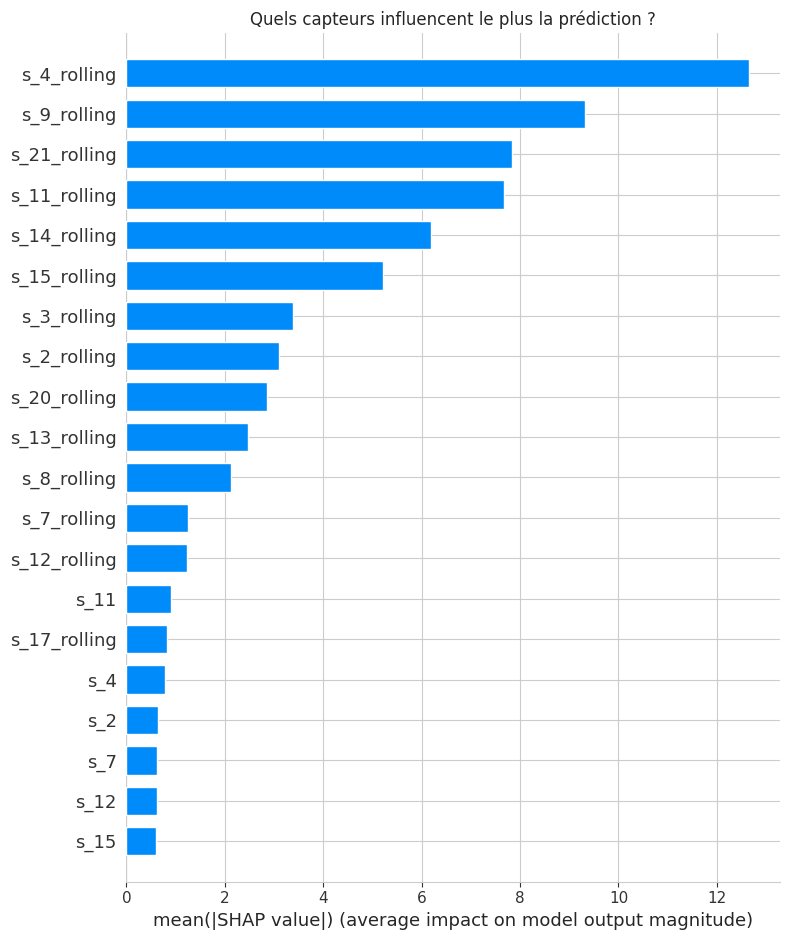

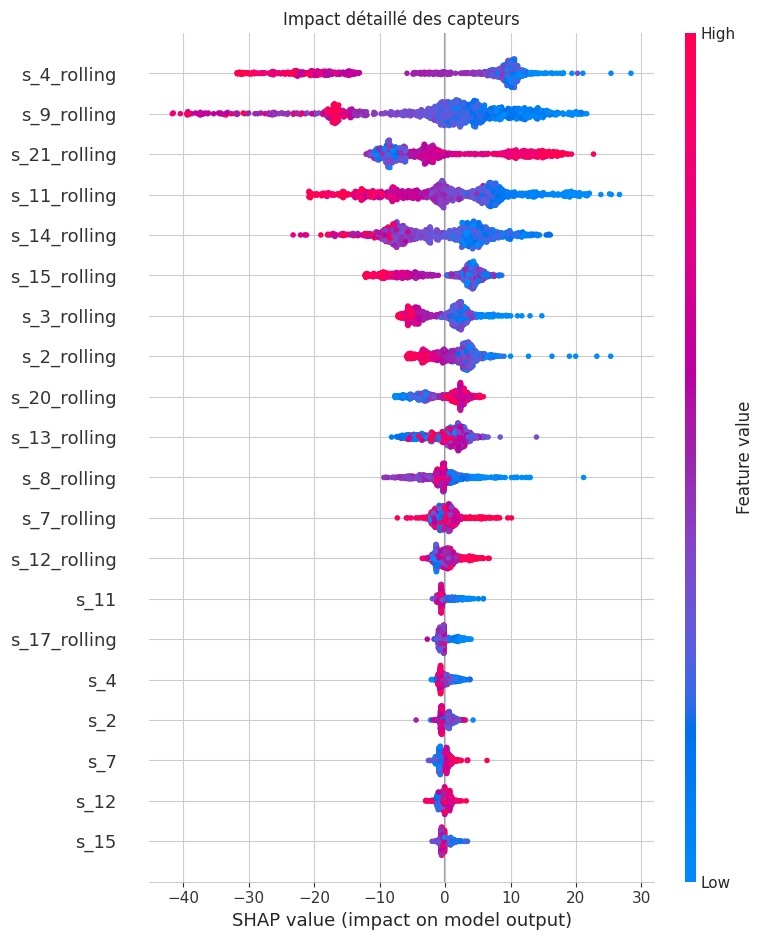

In [38]:
# --- : INTERPRÉTABILITÉ DU MODÈLE (SHAP) ---
import shap

print("🧠 Calcul des valeurs SHAP (Explication du modèle)...")

# On utilise un échantillon pour aller plus vite
X_sample = X_train.sample(1000, random_state=42)

# Création de l'explainer
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_sample)

# 1. Summary Plot (Le graphique le plus puissant en Data Science)
# Il montre quel capteur impacte le plus la prédiction (haut vers bas)
plt.title("Quels capteurs influencent le plus la prédiction ?")
shap.summary_plot(shap_values, X_sample, plot_type="bar")

# 2. Beeswarm Plot (Pour comprendre le sens de l'impact)
# Rouge = Valeur élevée du capteur -> Impact sur la RUL
plt.title("Impact détaillé des capteurs")
shap.summary_plot(shap_values, X_sample)

In [39]:

plt.savefig("resultats_prediction.png", dpi=300, bbox_inches='tight') # <-- Sauvegarde HD
plt.show()

<Figure size 1200x600 with 0 Axes>